In [1]:
from soursop.sstrajectory import parallel_load_trjs
from soursop.sstrajectory import SSTrajectory
import matplotlib.pyplot as plt
from starling.utilities import symmetrize_distance_maps
import numpy as np
from starling.models.vae import VAE
import torch
from einops import rearrange
import h5py
import hdf5plugin
from starling.data.tokenizer import StarlingTokenizer
from collections import defaultdict

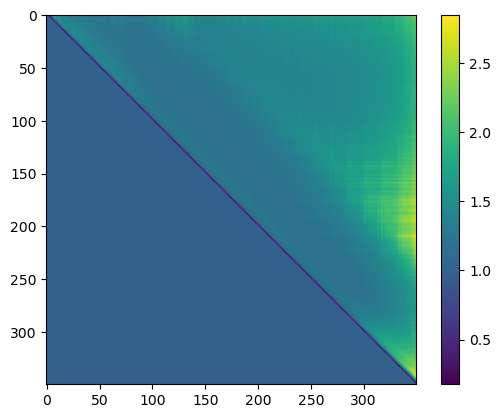

In [30]:
plt.imshow(torch.exp(new_model_1e6.log_std).detach().cpu()[:350, :350])
plt.colorbar()

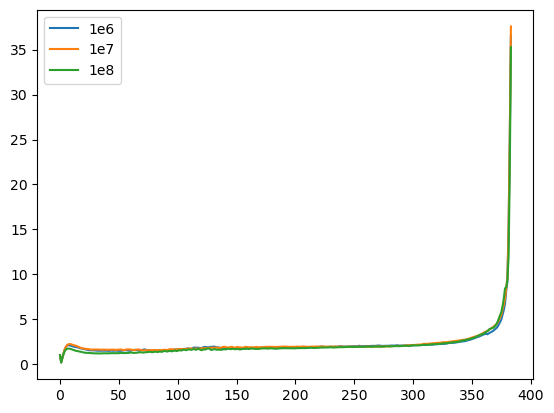

In [ ]:
plt.plot(
    torch.exp(new_model_1e6.log_std).detach().cpu()[0], label="1e6")

plt.plot(
    torch.exp(new_model_1e7.log_std).detach().cpu()[0], label="1e7")

plt.plot(
    torch.exp(new_model_1e8.log_std).detach().cpu()[0], label="1e8")

plt.legend()

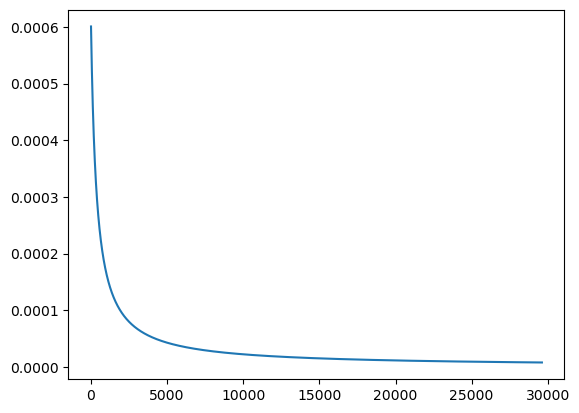

In [4]:
data = np.arange(3.81, 300, 0.01)

weights = 1 / data

max_norm_weights = weights / np.max(weights)

norm_weights = weights / np.sum(weights)

# relative_weights = weights / np.max(weights)

# plt.plot(max_norm_weights, label="max norm weights")
plt.plot(norm_weights, label="norm weights")

In [48]:
relative_weights

array([1.        , 0.9973822 , 0.99477807, ..., 0.01270127, 0.01270085,
       0.01270042])

In [ ]:
def load_hdf5_data(file_path):
    """
    Loads data from an HDF5 file and returns the distance maps.

    Parameters:
    - file_path (str): Path to the HDF5 file.

    Returns:
    - numpy.ndarray: Distance maps loaded from the file.
    """
    tokenizer = StarlingTokenizer()
    with h5py.File(file_path, "r") as f:
        # Assuming the dataset is named 'distance_maps'
        if 'dm' in f:
            data = f['dm'][:]
            seq = tokenizer.decode(f['seq'][:])
            # return data, seq
            if 150 < len(seq) < 400:
                return data, seq
            else:
                return None, None
        else:
            raise KeyError("Dataset 'distance_maps' not found in the HDF5 file.")

def encode_data(model, data):
    """
    Encodes data using the provided VAE model in batches of 32.

    Parameters:
    - model (VAE): The VAE model to use for encoding.
    - data (numpy.ndarray): Data to be encoded.

    Returns:
    - numpy.ndarray: Encoded data.
    """
    batch_size = 128
    device = next(model.parameters()).device  # Get model's device dynamically

    # Process data in batches
    encoded_batches = []
    with torch.no_grad():  # Move this outside the loop for efficiency
        # Process batches
        for i in range(0, len(data), batch_size):
            batch = data[i : i + batch_size]
            batch_tensor = torch.from_numpy(batch).to(device)
            batch_tensor = rearrange(batch_tensor, "b h w -> b 1 h w")
            encoded_batch = model.encode(batch_tensor).sample()
            
            encoded_batches.append(encoded_batch.cpu().numpy())

            # Optional: clear GPU memory (only if memory issues occur)
            # torch.cuda.empty_cache()

    # Concatenate all batches
    encoded_data = np.concatenate(encoded_batches, axis=0).squeeze()

    return encoded_data


def latent_kld(model, data):
    """
    Computes the Kullback-Leibler divergence using the provided VAE model in batches of 32.

    Parameters:
    - model (VAE): The VAE model to use for encoding.
    - data (numpy.ndarray): Data to be encoded.

    Returns:
    - numpy.ndarray: Encoded data.
    """
    batch_size = 8
    device = next(model.parameters()).device  # Get model's device dynamically

    # Process data in batches
    kld_losses = defaultdict(list)
    with torch.no_grad():  # Move this outside the loop for efficiency
        # Process batches
        for i in range(0, len(data), batch_size):
            batch = data[i : i + batch_size]
            batch_tensor = torch.from_numpy(batch).to(device)
            batch_tensor = rearrange(batch_tensor, "b h w -> b 1 h w")
            moments = model.encode(batch_tensor)
            
            mu, logvar = moments.mean, moments.logvar
            KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=[1, 2, 3])

            sequence_lengths = (batch_tensor[:,:,0,:] != 0).sum(dim=[1, 2]) + 1
            for length, kld in zip(sequence_lengths, KLD):
                kld_losses[length.item()].append(kld.item())
    
    return kld_losses


def decode_data(model, data):
    """
    Decodes data using the provided VAE model in batches of 32.

    Parameters:
    - model (VAE): The VAE model to use for encoding.
    - data (numpy.ndarray): Data to be encoded.

    Returns:
    - numpy.ndarray: Encoded data.
    """
    batch_size = 128
    device = next(model.parameters()).device  # Get model's device dynamically

    # Process data in batches
    decoded_batches = []
    with torch.no_grad():  # Move this outside the loop for efficiency
        # Process batches
        for i in range(0, len(data), batch_size):
            batch = data[i : i + batch_size]
            batch_tensor = torch.from_numpy(batch).to(device)
            batch_tensor = rearrange(batch_tensor, "b h w -> b 1 h w")
            encoded_batch = model.encode(batch_tensor).sample()
            decoded_batch = model.decode(encoded_batch)
            
            decoded_batches.append(decoded_batch.cpu().numpy())

            # Optional: clear GPU memory (only if memory issues occur)
            # torch.cuda.empty_cache()

    # Concatenate all batches
    decoded_data = np.concatenate(decoded_batches, axis=0).squeeze()

    return decoded_data


In [4]:
preprint_VAE = VAE.load_from_checkpoint(
    "/home/borna/.starling_weights/model-kernel-epoch=99-epoch_val_loss=1.72.ckpt",
    map_location="cuda",
)
preprint_VAE.eval()

new_model_1e8 = VAE.load_from_checkpoint(
    "/work/bnovak/projects/sequence2ensemble/vae_training/resnet18_KLD_1e8_warmup_0_1_Adam_1e4/model-kernel-epoch=99-epoch_val_loss=1.65.ckpt",
    map_location="cuda",
)
new_model_1e8.eval()

new_model_1e7 = VAE.load_from_checkpoint(
    "/work/bnovak/projects/sequence2ensemble/vae_training/resnet18_KLD_1e7_cyclical_Adam_1e4_apply_filter_true/model-kernel-epoch=57-epoch_val_loss=1.69.ckpt",
    map_location="cuda",
)

new_model_1e7.eval()

new_model_1e6 = VAE.load_from_checkpoint(
    "/work/bnovak/projects/sequence2ensemble/vae_training/resnet18_KLD_1e6_cyclical_Adam_1e4_apply_filter_true/model-kernel-epoch=73-epoch_val_loss=1.67.ckpt",
    map_location="cuda",
)
new_model_1e6.eval()

new_model_1e5 = VAE.load_from_checkpoint(
    "/work/bnovak/projects/sequence2ensemble/vae_training/resnet18_KLD_1e5_warmup_0_5_Adam_1e4/model-kernel-epoch=69-epoch_val_loss=1.69.ckpt",
    map_location="cuda",
)
new_model_1e5.eval()

/home/borna/miniconda3/envs/labconda/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1.post0, which is newer than your current Lightning version: v2.4.0
/home/borna/miniconda3/envs/labconda/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.2, which is newer than your current Lightning version: v2.4.0


VAE(
  (encoder): ResNet_Encoder(
    (first_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (layer1): ModuleList(
      (0-1): 2 x ResBlockEncBasic(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (activation1): ReLU(inplace=True)
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (shortcut): Sequential()
        (activation): ReLU(inplace=True)
      )
    )
    (layer2): ModuleList(
      (0): ResBlockEncBasic(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm1): Instan

In [5]:
import glob

files = glob.glob('/work/bnovak/projects/sequence2ensemble/lammps_data/150mM_data/mPIPIgg_70k_seqs/IDRs_0003/preprocessed_data/*h5')

files = [i for i in files if 'vae_encoded' not in i]

In [6]:
# files = np.random.choice(files, size=100, replace=False)

In [7]:
import glob

data = [load_hdf5_data(i) for i in files]

dm, seq = zip(*data)

dm = [i for i in dm if i is not None]
seq = [i for i in seq if i is not None]

In [8]:
# import sparrow

repeat_counts = [len(i) for i in dm]

# labels = [
#     kappa for i, count in zip(seq, repeat_counts)
#     for kappa in [sparrow.Protein(i).predictor.radius_of_gyration()] * count
# ]

labels = [
    kappa for i, count in zip(seq, repeat_counts)
    for kappa in [len(i)] * count
]

In [9]:
data = np.concatenate(dm, axis=0)

In [33]:
preprint_latent_kld = latent_kld(preprint_VAE, data)
new_latent_kld_1e8 = latent_kld(new_model_1e8, data)

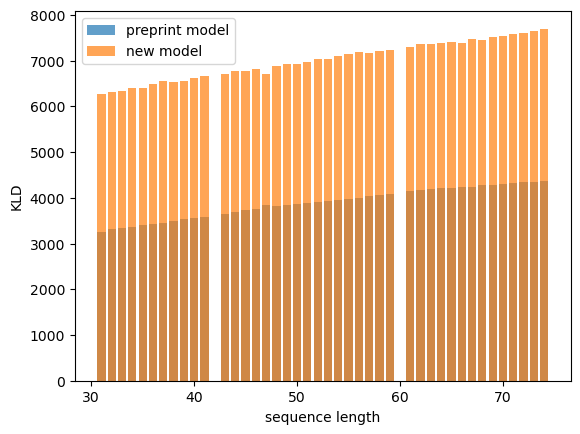

In [43]:
plt.bar([key for key in preprint_latent_kld], [np.mean(preprint_latent_kld[key]) for key in preprint_latent_kld],label='preprint model', alpha=0.7)

plt.bar([key for key in new_latent_kld_1e8], [np.mean(new_latent_kld_1e8[key]) for key in new_latent_kld_1e8], label='new model', alpha=0.7)

plt.xlabel('sequence length')

plt.ylabel('KLD')

plt.legend()

<BarContainer object of 23 artists>

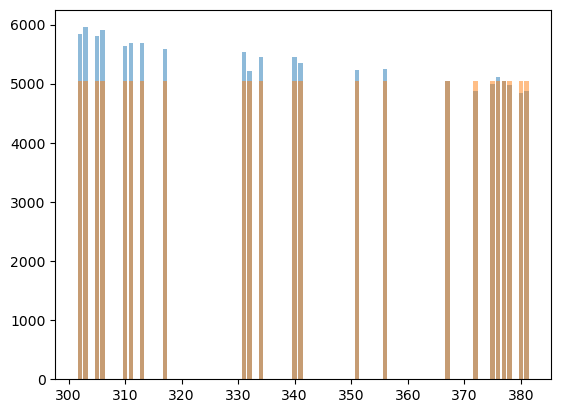

In [17]:
weights = np.array([key for key in new_latent_kld_1e5]) / np.array([key for key in new_latent_kld_1e5]).max()


plt.bar([key for key in new_latent_kld_1e5], np.array([np.mean(new_latent_kld_1e5[key]) for key in new_latent_kld_1e5])/weights, alpha=0.5)

plt.bar([key for key in preprint_latent_kld], [np.mean(preprint_latent_kld[key]) for key in preprint_latent_kld],label='preprint model', alpha=0.5)

In [10]:
preprint_encoded_data = encode_data(preprint_VAE, data)
new_encoded_data_1e8 = encode_data(new_model_1e8, data)
new_encoded_data_1e7 = encode_data(new_model_1e7, data)
new_encoded_data_1e6 = encode_data(new_model_1e6, data)
new_encoded_data_1e5 = encode_data(new_model_1e5, data)

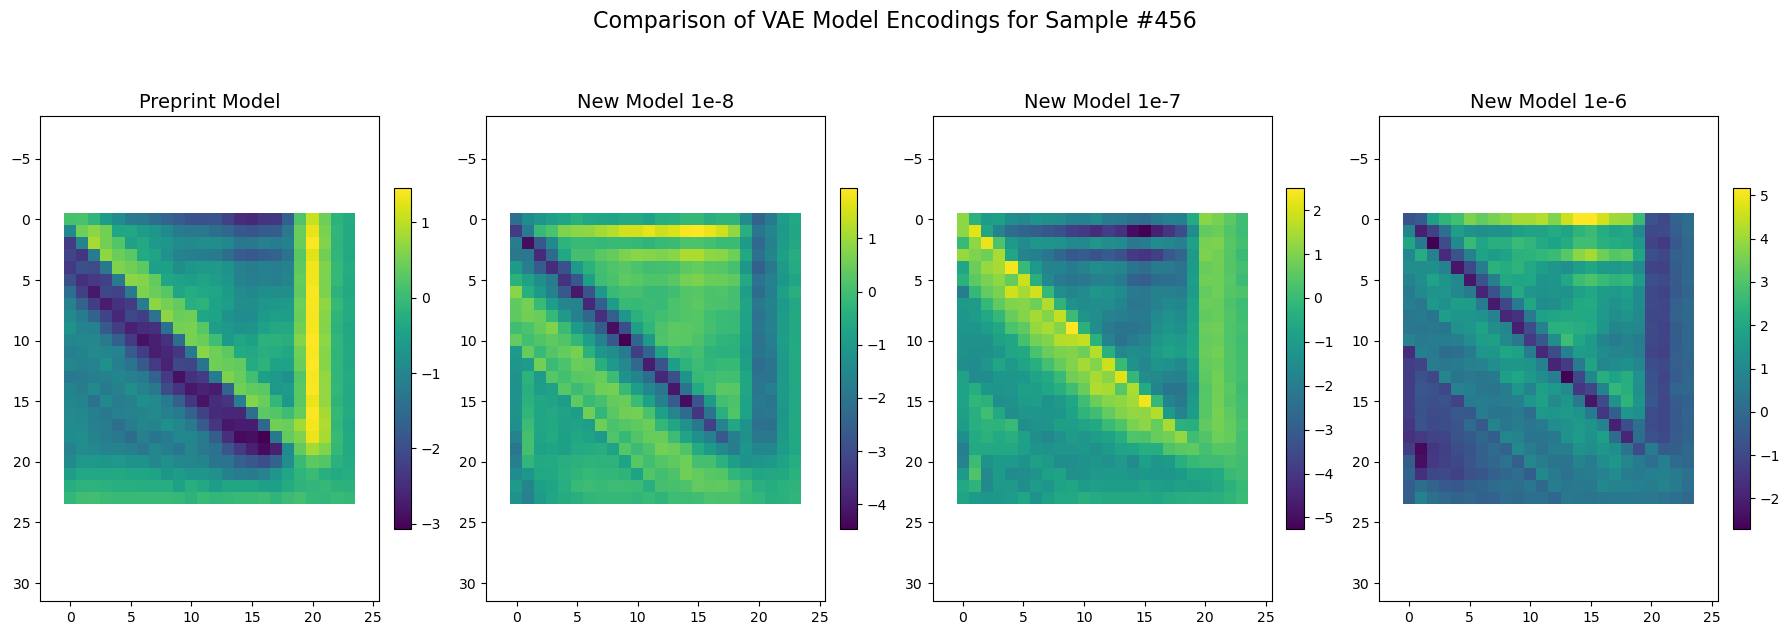

In [11]:
sample = 456

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

# Plot image from preprint model
# Create histogram for new model (1e-4)
latent_space = preprint_encoded_data
latent_space = latent_space / latent_space.std()
im1 = axes[0].imshow(latent_space[sample], cmap='viridis')
axes[0].set_title('Preprint Model', fontsize=14)
axes[0].axis('equal')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Plot image from new model
latent_space = new_encoded_data_1e8
latent_space = latent_space / latent_space.std()
im2 = axes[1].imshow(latent_space[sample], cmap='viridis')
axes[1].set_title('New Model 1e-8', fontsize=14)
axes[1].axis('equal')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Plot image from new model
latent_space = new_encoded_data_1e7
latent_space = latent_space / latent_space.std()
im2 = axes[2].imshow(latent_space[sample], cmap='viridis')
axes[2].set_title('New Model 1e-7', fontsize=14)
axes[2].axis('equal')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)


# Plot difference between models
latent_space = new_encoded_data_1e6
latent_space = latent_space / latent_space.std()
im3 = axes[3].imshow(latent_space[sample], cmap='viridis')
axes[3].set_title('New Model 1e-6', fontsize=14)
axes[3].axis('equal')
fig.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)


# Add overall title
plt.suptitle(f'Comparison of VAE Model Encodings for Sample #{sample}', fontsize=16, y=1.05)

# Ensure proper spacing
plt.tight_layout()

plt.show()

In [12]:
print('Preprint Mean', preprint_encoded_data.mean(), 'Std', preprint_encoded_data.std())

print('New Model Mean 1e-8', new_encoded_data_1e8.mean(), 'Std', new_encoded_data_1e8.std())

print('New Model Mean 1e-7', new_encoded_data_1e7.mean(), 'Std', new_encoded_data_1e7.std())

print('New Model Mean 1e-6', new_encoded_data_1e6.mean(), 'Std', new_encoded_data_1e6.std())

print('New Model Mean 1e-5', new_encoded_data_1e5.mean(), 'Std', new_encoded_data_1e5.std())

Preprint Mean -1.1620309 Std 1.7032701
New Model Mean 1e-8 -24.552525 Std 43.55939
New Model Mean 1e-7 -8.093913 Std 17.851297
New Model Mean 1e-6 2.306175 Std 5.914158
New Model Mean 1e-5 -0.56648606 Std 2.1183217


/tmp/ipykernel_497155/196621609.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axes[0].plot(x, normal_pdf, 'k-', linewidth=2, color=line_color, label='N(0,1)')
/tmp/ipykernel_497155/196621609.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axes[1].plot(x, normal_pdf, 'k-', linewidth=2, color=line_color, label='N(0,1)')
/tmp/ipykernel_497155/196621609.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axes[2].plot(x, normal_pdf, 'k-', linewidth=2, color=line_color, label='N(0,1)')
/tmp/ipykernel_497155/196621609.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keywor

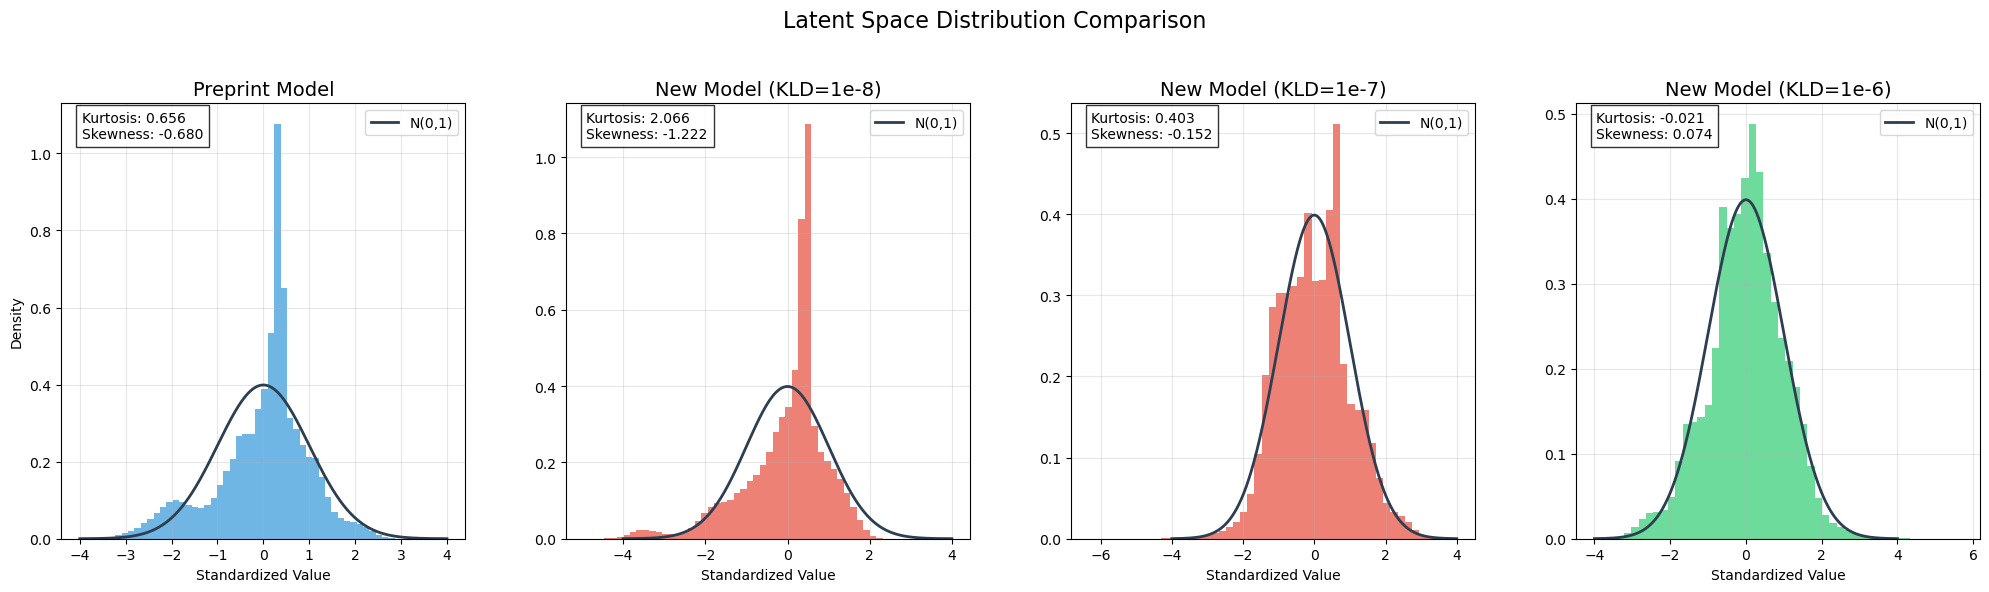

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from einops import rearrange

# Set up the figure with 3 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('Latent Space Distribution Comparison', fontsize=16)

# Define a range for plotting the normal distribution
x = np.linspace(-4, 4, 1000)
normal_pdf = stats.norm.pdf(x)

# Create color palette
colors = ['#3498db', '#e74c3c', '#2ecc71']
line_color = '#2c3e50'

# Create histogram for preprint model
latent_space = preprint_encoded_data
flattened = rearrange(((latent_space - latent_space.mean()) / latent_space.std()), "b h w -> (b h w)")

axes[0].hist(flattened, bins=50, alpha=0.7, density=True, color=colors[0])
axes[0].plot(x, normal_pdf, 'k-', linewidth=2, color=line_color, label='N(0,1)')
axes[0].set_title('Preprint Model', fontsize=14)
# axes[0].set_xlim(-4, 4)
axes[0].set_xlabel('Standardized Value')
axes[0].set_ylabel('Density')
axes[0].grid(alpha=0.3)
axes[0].legend()

# Create histogram for new model (1e-6)
latent_space = new_encoded_data_1e8
flattened = rearrange(((latent_space - latent_space.mean()) / latent_space.std()), "b h w -> (b h w)")

axes[1].hist(flattened, bins=50, alpha=0.7, density=True, color=colors[1])
axes[1].plot(x, normal_pdf, 'k-', linewidth=2, color=line_color, label='N(0,1)')
axes[1].set_title('New Model (KLD=1e-8)', fontsize=14)
# axes[1].set_xlim(-4, 4)
axes[1].set_xlabel('Standardized Value')
axes[1].grid(alpha=0.3)
axes[1].legend()

# Create histogram for new model (1e-5)
latent_space = new_encoded_data_1e7
flattened = rearrange(((latent_space - latent_space.mean()) / latent_space.std()), "b h w -> (b h w)")

axes[2].hist(flattened, bins=50, alpha=0.7, density=True, color=colors[1])
axes[2].plot(x, normal_pdf, 'k-', linewidth=2, color=line_color, label='N(0,1)')
axes[2].set_title('New Model (KLD=1e-7)', fontsize=14)
# axes[1].set_xlim(-4, 4)
axes[2].set_xlabel('Standardized Value')
axes[2].grid(alpha=0.3)
axes[2].legend()

# Create histogram for new model (1e-4)
latent_space = new_encoded_data_1e6
flattened = rearrange(((latent_space - latent_space.mean()) / latent_space.std()), "b h w -> (b h w)")

axes[3].hist(flattened, bins=50, alpha=0.7, density=True, color=colors[2])
axes[3].plot(x, normal_pdf, 'k-', linewidth=2, color=line_color, label='N(0,1)')
axes[3].set_title('New Model (KLD=1e-6)', fontsize=14)
# axes[2].set_xlim(-4, 4)
axes[3].set_xlabel('Standardized Value')
axes[3].grid(alpha=0.3)
axes[3].legend()


# Add statistical data
for i, (title, encoded_data) in enumerate([
    ("Preprint", preprint_encoded_data),
    ("New (1e-8)", new_encoded_data_1e8),
    ("New (1e-6)", new_encoded_data_1e6),
    ("New (1e-7)", new_encoded_data_1e7),
]):
    normalized = rearrange(((encoded_data - encoded_data.mean()) / encoded_data.std()), "b h w -> (b h w)")
    kurtosis = stats.kurtosis(normalized)
    skewness = stats.skew(normalized)
    axes[i].text(0.05, 0.92, f"Kurtosis: {kurtosis:.3f}\nSkewness: {skewness:.3f}", 
                transform=axes[i].transAxes, bbox=dict(facecolor='white', alpha=0.8))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make space for the suptitle
plt.subplots_adjust(wspace=0.25)  # Add space between subplots

# # Save or display
# plt.savefig('latent_space_distribution.png', dpi=300, bbox_inches='tight')
# plt.show()

/tmp/ipykernel_497155/612573909.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


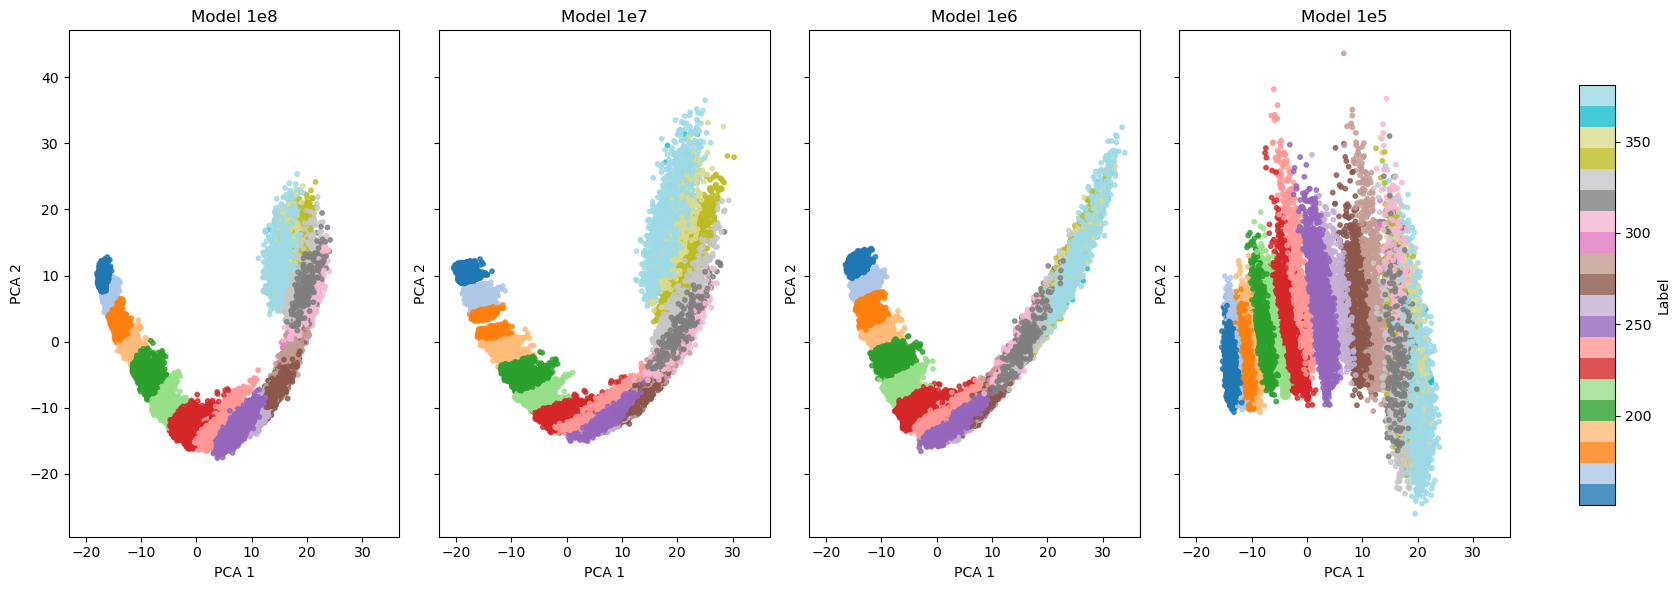

In [14]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA  # Add this import
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange  # If you're using rearrange

# Define your two datasets
datasets = {
    "Model 1e8": new_encoded_data_1e8,
    "Model 1e7": new_encoded_data_1e7,
    "Model 1e6": new_encoded_data_1e6,
    "Model 1e5": new_encoded_data_1e5,
}

labels = np.array(labels)

# Plot setup
fig, axs = plt.subplots(1, 4, figsize=(18, 6), sharex=True, sharey=True)

for ax, (title, data_to_plot) in zip(axs, datasets.items()):
    # Flatten and normalize
    flat_latents = rearrange(data_to_plot, "b h w -> b (h w)")
    flat_latents = StandardScaler().fit_transform(flat_latents)
    
    # Step 2: Apply PCA (for quick linear overview)
    pca = PCA(n_components=2)
    pca_latents = pca.fit_transform(flat_latents)

    
    # Scatter plot
    scatter = ax.scatter(pca_latents[:, 0], pca_latents[:, 1], c=labels, cmap='tab20', s=10, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    
# Add a single colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(scatter, cax=cbar_ax, label="Label")


plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

/tmp/ipykernel_497155/1033717013.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


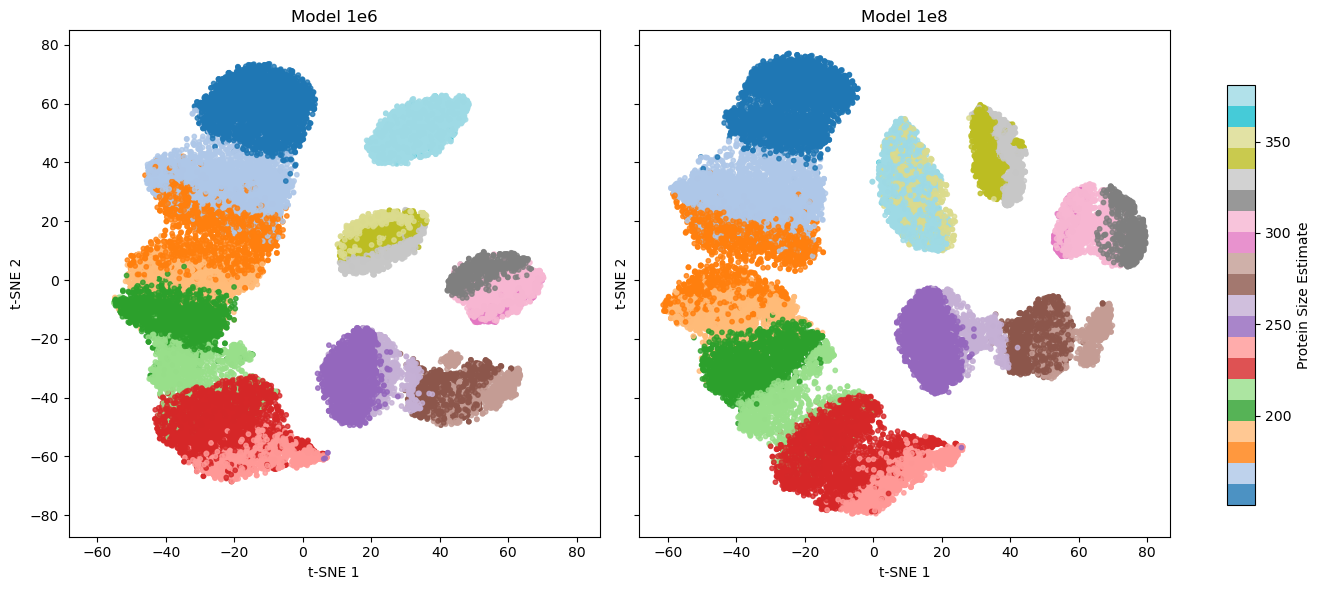

In [15]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange  # If you're using rearrange

# Define your two datasets
datasets = {
    "Model 1e6": new_encoded_data_1e6,
    "Model 1e8": new_encoded_data_1e8
}

# # Compute labels once
# labels = [[(dm[0] != 0).sum().item() + 1 for dm in ensemble] for ensemble in data]
# labels = np.concatenate(labels)

labels = []
for dm in data:
    # Count non-zero elements in the first row of each distance map
    length = (dm[0] != 0).sum().item() + 1
    labels.append(length)
labels = np.array(labels)

# Plot setup
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

for ax, (title, data_to_plot) in zip(axs, datasets.items()):
    # Flatten and normalize
    flat_latents = rearrange(data_to_plot, "b h w -> b (h w)")
    flat_latents = StandardScaler().fit_transform(flat_latents)
    
    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init='pca', random_state=42)
    tsne_latents = tsne.fit_transform(flat_latents)

    
    # Scatter plot
    scatter = ax.scatter(tsne_latents[:, 0], tsne_latents[:, 1], c=labels, cmap='tab20', s=10, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

# Add a single colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(scatter, cax=cbar_ax, label="Protein Size Estimate")

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [21]:
test = rearrange(preprint_encoded_data, "b h w -> b (h w)")

np.random.choice(test, size=1000, replace=False)

ValueError: a must be 1-dimensional

/home/borna/miniconda3/envs/labconda/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/borna/miniconda3/envs/labconda/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/tmp/ipykernel_678760/1919186166.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


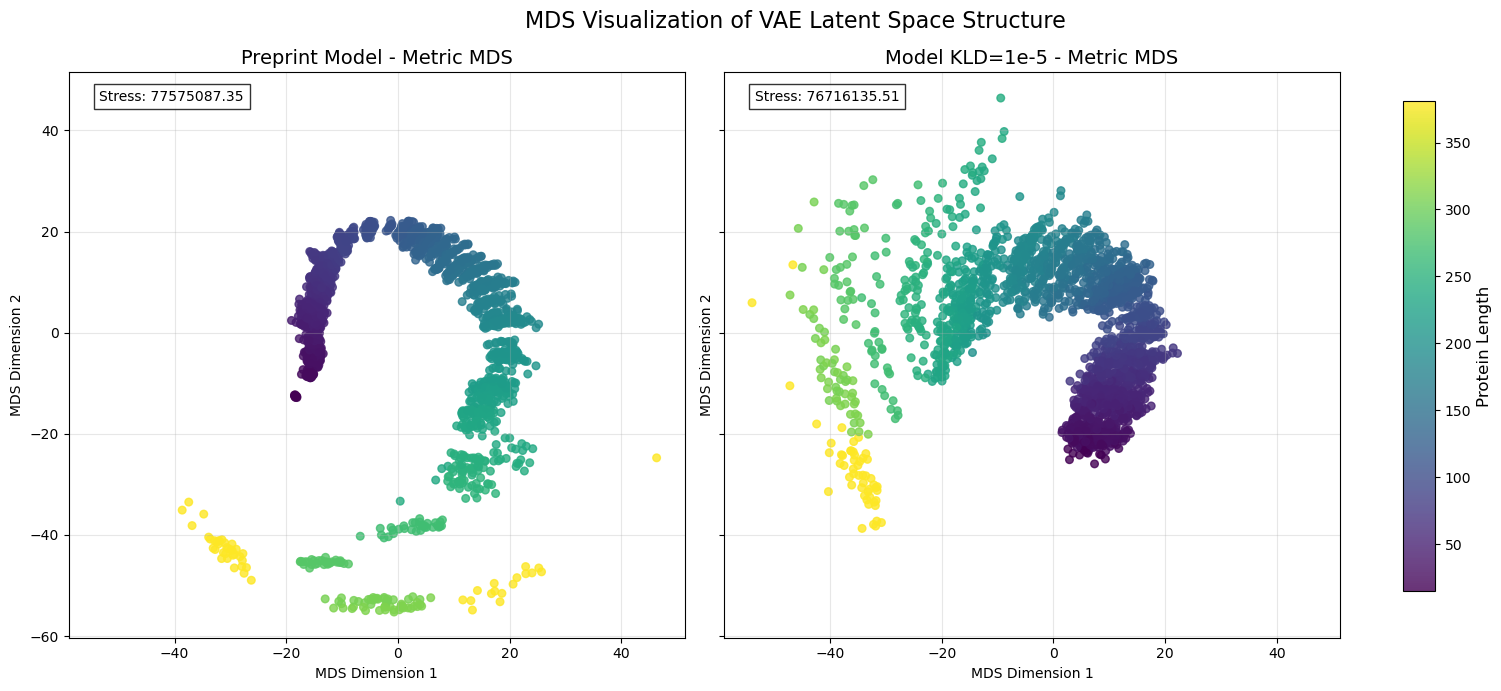

In [29]:
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange

# Define the datasets you want to compare
datasets = {
    "Preprint Model": preprint_encoded_data,
    "Model KLD=1e-5": new_encoded_data_1e5
}

labels = []
for dm in data:
    # Count non-zero elements in the first row of each distance map
    length = (dm[0] != 0).sum().item() + 1
    labels.append(length)
labels = np.array(labels)

indices = np.random.choice(np.arange(datasets['Model KLD=1e-5'].shape[0]), size=2000, replace=False)

# Set up the plot
fig, axs = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)
fig.suptitle("MDS Visualization of VAE Latent Space Structure", fontsize=16)

# Process each model
for ax, (title, data_to_plot) in zip(axs, datasets.items()):
    # Flatten the latent representations
    flat_latents = rearrange(data_to_plot[indices], "b h w -> b (h w)")
    
    # Standardize the data
    flat_latents = StandardScaler().fit_transform(flat_latents)
    
    # Reduce dimensionality
    flat_latents = PCA(n_components=50).fit_transform(flat_latents)
    
    # Apply MDS - try both metric and non-metric versions
    mds = MDS(n_components=2, metric=True, random_state=42, n_jobs=-1)
    mds_latents = mds.fit_transform(flat_latents)
    
    # Color by protein size
    scatter = ax.scatter(mds_latents[:, 0], mds_latents[:, 1], 
                         c=labels[indices], cmap='viridis', s=30, alpha=0.8)
    
    # Add stress value (lower is better - indicates how well distances are preserved)
    stress_text = f"Stress: {mds.stress_:.2f}"
    ax.text(0.05, 0.95, stress_text, transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.8))
    
    ax.set_title(f"{title} - Metric MDS", fontsize=14)
    ax.set_xlabel("MDS Dimension 1")
    ax.set_ylabel("MDS Dimension 2")
    ax.grid(alpha=0.3)

# Add a single colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label("Protein Length", fontsize=12)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [38]:
# Create histogram for new model (1e-6)
latent_space = new_encoded_data_1e4
flattened = rearrange((latent_space / latent_space.std()), "b h w -> (b h w)")

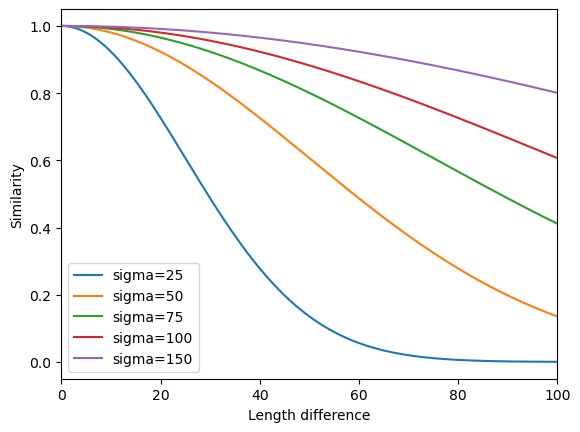

In [37]:
import torch
import matplotlib.pyplot as plt

length_diffs = torch.arange(0, 400)
for sigma in [25, 50, 75, 100, 150]:
    sim = torch.exp(-length_diffs**2 / (2 * sigma**2))
    plt.plot(length_diffs, sim, label=f'sigma={sigma}')
plt.xlabel("Length difference")
plt.ylabel("Similarity")
plt.legend()
plt.xlim([0, 100])
plt.show()


In [67]:
import math

def calculate_ramp_weight(step, cycle_fraction, ramp_fraction, max_weight=1.0, total_steps=2000):
    """
    Calculate weight using a ramp-up schedule followed by a plateau.
    
    Parameters:
    -----------
    step : int
        Current step in the training process
    cycle_fraction : float
        Fraction of total_steps that represents one cycle length
    ramp_fraction : float
        Fraction of cycle_length for the ramp-up phase
    max_weight : float, optional
        Maximum weight value (default: 1.0)
    total_steps : int, optional
        Total number of steps in training (default: 2000)
        
    Returns:
    --------
    float
        The calculated weight for the current step
    """
    cycle_length = int(cycle_fraction * total_steps)
    ramp_steps = int(ramp_fraction * cycle_length)
    
    cycle_step = step % cycle_length
    
    if cycle_step < ramp_steps:
        weight = (cycle_step / ramp_steps) * max_weight
    else:
        weight = max_weight
        
    return weight

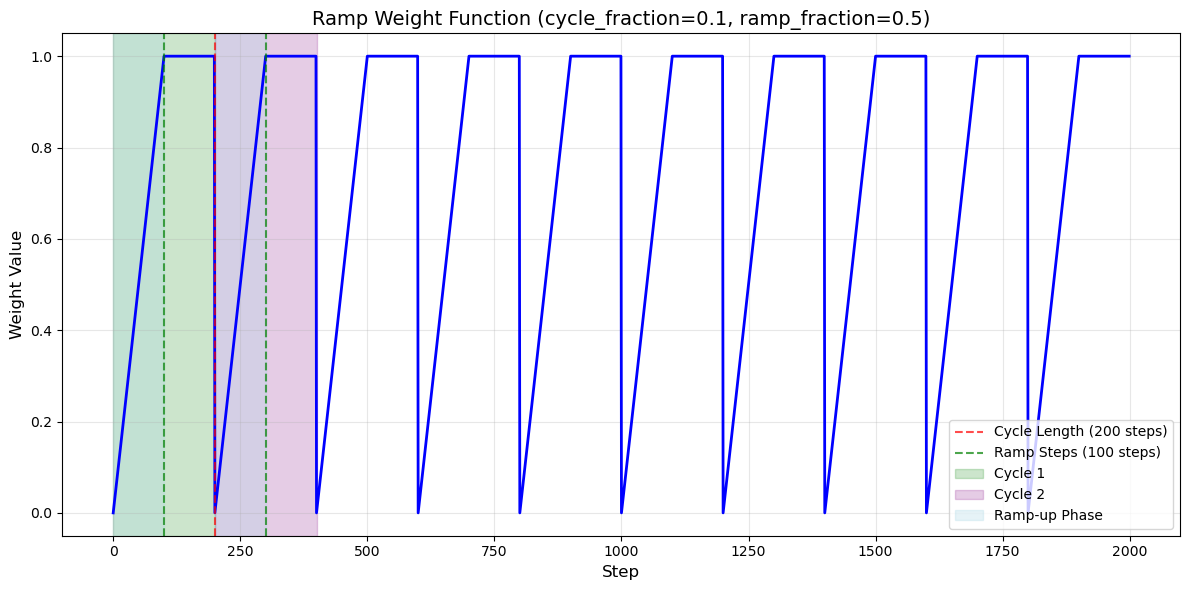

In [71]:
# Plot the ramp weight function with a cycle length of 1000 steps
import matplotlib.pyplot as plt
import numpy as np

# Generate step values for 2 complete cycles
total_steps = 2000
steps = np.arange(0, total_steps)
cycle_fraction = 0.1  # 50% of total steps = 1000 steps
ramp_fraction = 0.5   # 50% of cycle length = 500 steps
max_weight = 1.0

# Calculate weights for each step
weights = [calculate_ramp_weight(step, cycle_fraction, ramp_fraction, max_weight, total_steps) for step in steps]

# Calculate the actual step counts for annotations
cycle_length = int(cycle_fraction * total_steps)
ramp_steps = int(ramp_fraction * cycle_length)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(steps, weights, 'b-', linewidth=2)
plt.title(f'Ramp Weight Function (cycle_fraction={cycle_fraction}, ramp_fraction={ramp_fraction})', fontsize=14)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Weight Value', fontsize=12)
plt.grid(True, alpha=0.3)

# Add annotations for cycle boundaries
plt.axvline(x=cycle_length, color='r', linestyle='--', alpha=0.7, 
            label=f'Cycle Length ({cycle_length} steps)')

# Add annotation for ramp-up phase
plt.axvline(x=ramp_steps, color='g', linestyle='--', alpha=0.7, 
            label=f'Ramp Steps ({ramp_steps} steps)')
plt.axvline(x=cycle_length + ramp_steps, color='g', linestyle='--', alpha=0.7)

# Add shading to distinguish cycles
plt.axvspan(0, cycle_length, alpha=0.2, color='green', label='Cycle 1')
plt.axvspan(cycle_length, 2*cycle_length, alpha=0.2, color='purple', label='Cycle 2')

# Add shading for ramp-up phases
plt.axvspan(0, ramp_steps, alpha=0.3, color='lightblue', label='Ramp-up Phase')
plt.axvspan(cycle_length, cycle_length + ramp_steps, alpha=0.3, color='lightblue')

plt.legend(loc='best')
plt.tight_layout()
plt.show()